In [2]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
cloud_cover = pd.read_csv('Bangkhuntean_CloudCover_2021-16Nov-16Dec.csv',skipinitialspace = True)
cloud_cover.isnull().sum()

Year          0
Month         0
Day           0
Hour          0
Minute        0
Second        0
CloudCover    0
dtype: int64

In [4]:
cloud_cover['Date'] = cloud_cover[['Year', 'Month', 'Day']].apply(lambda x: "{0}-{1}-{2}".format(str(x[0]).zfill(2), str(x[1]).zfill(2), str(x[2]).zfill(2)), axis=1) 
cloud_cover['Time'] = cloud_cover[['Hour', 'Minute']].apply(lambda x: "{}:{}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Year", "Month", "Day", "Hour", "Minute", "Second"], axis=1, inplace=True)     
cloud_cover = cloud_cover.rename(columns={"CloudCover":"cloud_cover"})
cloud_cover = cloud_cover.groupby(['Date', 'Time']).agg(cloud_cover=('cloud_cover','mean')).reset_index()
cloud_cover['DateTime'] = cloud_cover[['Date', 'Time']].apply(lambda x: "{} {}".format(str(x[0]).zfill(2), str(x[1]).zfill(2)), axis=1)
cloud_cover.drop(["Date", "Time"], axis=1, inplace=True)        
cloud_cover['DateTime'] = pd.to_datetime(cloud_cover['DateTime'], format="%Y-%m-%d %H:%M")
cloud_cover.dropna(inplace=True)
cloud_cover

,cloud_cover,DateTime
0,0.990000,2021-11-16 11:15:00
1,0.989000,2021-11-16 11:16:00
2,0.987667,2021-11-16 11:17:00
3,0.987000,2021-11-16 11:18:00
4,0.987000,2021-11-16 11:19:00
...,...,...
15056,0.168000,2021-12-16 13:58:00
15057,0.169000,2021-12-16 13:59:00
15058,0.147000,2021-12-16 14:00:00
15059,0.145000,2021-12-16 14:01:00


<AxesSubplot: >

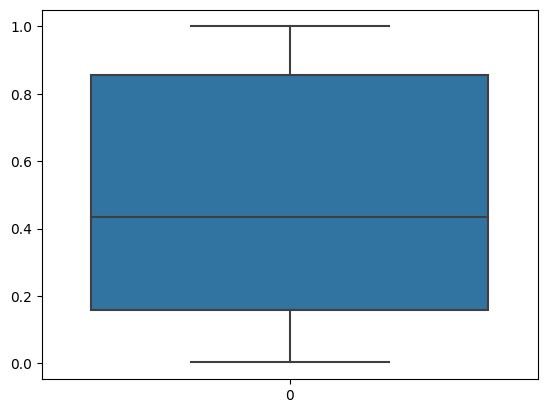

In [5]:
sns.boxplot(cloud_cover['cloud_cover'])

In [6]:
df = cloud_cover[['DateTime', 'cloud_cover']]
df.columns = ['ds', 'y']
df

,ds,y
0,2021-11-16 11:15:00,0.990000
1,2021-11-16 11:16:00,0.989000
2,2021-11-16 11:17:00,0.987667
3,2021-11-16 11:18:00,0.987000
4,2021-11-16 11:19:00,0.987000
...,...,...
15056,2021-12-16 13:58:00,0.168000
15057,2021-12-16 13:59:00,0.169000
15058,2021-12-16 14:00:00,0.147000
15059,2021-12-16 14:01:00,0.145000


# TimeSeriesSplit for cross validation

In [7]:
cv = TimeSeriesSplit(n_splits=5)
# i = 0
for train,test in cv.split(df):
    print('TRAIN:', train, 'TEST:', test) 
    i=i+1
    print ("No of observations under train%s=%s" % (i, len(train)))
    print ("No of observations under test%s=%s" % (i, len(test)))

TRAIN: [   0    1    2 ... 2508 2509 2510] TEST: [2511 2512 2513 ... 5018 5019 5020]
No of observations under train1=2511
No of observations under test1=2510
TRAIN: [   0    1    2 ... 5018 5019 5020] TEST: [5021 5022 5023 ... 7528 7529 7530]
No of observations under train2=5021
No of observations under test2=2510
TRAIN: [   0    1    2 ... 7528 7529 7530] TEST: [ 7531  7532  7533 ... 10038 10039 10040]
No of observations under train3=7531
No of observations under test3=2510
TRAIN: [    0     1     2 ... 10038 10039 10040] TEST: [10041 10042 10043 ... 12548 12549 12550]
No of observations under train4=10041
No of observations under test4=2510
TRAIN: [    0     1     2 ... 12548 12549 12550] TEST: [12551 12552 12553 ... 15058 15059 15060]
No of observations under train5=12551
No of observations under test5=2510


In [8]:
train1, test1 = df.iloc[:2511], df.iloc[2511:5021]
train2, test2 = df.iloc[:5021], df.iloc[5021:7531]
train3, test3 = df.iloc[:7531], df.iloc[7531:10041]
train4, test4 = df.iloc[:10041], df.iloc[10041:12551]
train5, test5 = df.iloc[:12551], df.iloc[12551:15061]

In [9]:
model1 = Prophet()
model1.fit(train1)
pred1 = model1.predict(test1)
pred1

13:45:27 - cmdstanpy - INFO - Chain [1] start processing
13:45:28 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-21 08:06:00,0.755565,0.654711,1.040371,0.755565,0.755565,0.086701,0.086701,0.086701,0.086701,0.086701,0.086701,0.0,0.0,0.0,0.842266
1,2021-11-21 08:07:00,0.755911,0.659206,1.022974,0.755911,0.755911,0.085370,0.085370,0.085370,0.085370,0.085370,0.085370,0.0,0.0,0.0,0.841282
2,2021-11-21 08:08:00,0.756258,0.659139,1.038687,0.756258,0.756258,0.084037,0.084037,0.084037,0.084037,0.084037,0.084037,0.0,0.0,0.0,0.840295
3,2021-11-21 08:09:00,0.756604,0.659604,1.017982,0.756604,0.756604,0.082702,0.082702,0.082702,0.082702,0.082702,0.082702,0.0,0.0,0.0,0.839306
4,2021-11-21 08:10:00,0.756951,0.651864,1.034074,0.756951,0.756951,0.081366,0.081366,0.081366,0.081366,0.081366,0.081366,0.0,0.0,0.0,0.838317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,2021-11-25 13:52:00,2.871279,0.798480,5.684915,0.573176,5.469121,0.222248,0.222248,0.222248,0.222248,0.222248,0.222248,0.0,0.0,0.0,3.093527
2506,2021-11-25 13:53:00,2.871625,0.753795,5.687373,0.572278,5.469731,0.219672,0.219672,0.219672,0.219672,0.219672,0.219672,0.0,0.0,0.0,3.091297
2507,2021-11-25 13:54:00,2.871972,0.812997,5.701482,0.571379,5.470341,0.217075,0.217075,0.217075,0.217075,0.217075,0.217075,0.0,0.0,0.0,3.089047
2508,2021-11-25 13:55:00,2.872318,0.759225,5.662786,0.570481,5.470951,0.214459,0.214459,0.214459,0.214459,0.214459,0.214459,0.0,0.0,0.0,3.086777


In [10]:
model2 = Prophet()
model2.fit(train2)
pred2 = model2.predict(test2)
pred2

13:45:30 - cmdstanpy - INFO - Chain [1] start processing
13:45:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-25 13:57:00,0.127903,0.071315,0.571953,0.127903,0.127903,0.202768,0.202768,0.202768,0.202768,0.202768,0.202768,0.0,0.0,0.0,0.330672
1,2021-11-25 13:58:00,0.127663,0.086079,0.578088,0.127663,0.127663,0.200682,0.200682,0.200682,0.200682,0.200682,0.200682,0.0,0.0,0.0,0.328345
2,2021-11-25 13:59:00,0.127423,0.075868,0.572989,0.127423,0.127423,0.198594,0.198594,0.198594,0.198594,0.198594,0.198594,0.0,0.0,0.0,0.326018
3,2021-11-25 14:00:00,0.127184,0.062781,0.574770,0.127184,0.127184,0.196507,0.196507,0.196507,0.196507,0.196507,0.196507,0.0,0.0,0.0,0.323691
4,2021-11-25 14:01:00,0.126944,0.085892,0.557923,0.126944,0.126944,0.194420,0.194420,0.194420,0.194420,0.194420,0.194420,0.0,0.0,0.0,0.321364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,2021-11-30 10:42:00,-1.552706,-3.580061,1.029207,-3.870352,0.722315,0.287608,0.287608,0.287608,0.287608,0.287608,0.287608,0.0,0.0,0.0,-1.265098
2506,2021-11-30 10:43:00,-1.552946,-3.599446,1.019203,-3.872365,0.722733,0.289301,0.289301,0.289301,0.289301,0.289301,0.289301,0.0,0.0,0.0,-1.263645
2507,2021-11-30 10:44:00,-1.553186,-3.647948,1.011841,-3.874379,0.723150,0.290983,0.290983,0.290983,0.290983,0.290983,0.290983,0.0,0.0,0.0,-1.262203
2508,2021-11-30 10:45:00,-1.553426,-3.661462,1.078063,-3.876393,0.723568,0.292654,0.292654,0.292654,0.292654,0.292654,0.292654,0.0,0.0,0.0,-1.260772


In [11]:
model3 = Prophet()
model3.fit(train3)
pred3 = model3.predict(test3)
pred3

13:45:40 - cmdstanpy - INFO - Chain [1] start processing
13:45:49 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-11-30 10:47:00,0.727019,0.676142,1.215856,0.727019,0.727019,0.231987,0.231987,0.231987,0.231987,0.231987,0.231987,0.0,0.0,0.0,0.959006
1,2021-11-30 10:48:00,0.727192,0.685854,1.250744,0.727192,0.727192,0.233353,0.233353,0.233353,0.233353,0.233353,0.233353,0.0,0.0,0.0,0.960546
2,2021-11-30 10:49:00,0.727366,0.674067,1.237267,0.727366,0.727366,0.234710,0.234710,0.234710,0.234710,0.234710,0.234710,0.0,0.0,0.0,0.962076
3,2021-11-30 10:50:00,0.727539,0.686051,1.239982,0.727539,0.727539,0.236057,0.236057,0.236057,0.236057,0.236057,0.236057,0.0,0.0,0.0,0.963597
4,2021-11-30 10:51:00,0.727713,0.680639,1.263052,0.727713,0.727713,0.237394,0.237394,0.237394,0.237394,0.237394,0.237394,0.0,0.0,0.0,0.965107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,2021-12-04 16:32:00,1.785794,-0.253532,3.681408,-0.078266,3.748993,-0.032447,-0.032447,-0.032447,-0.032447,-0.032447,-0.032447,0.0,0.0,0.0,1.753347
2506,2021-12-04 16:33:00,1.785968,-0.152892,3.654365,-0.078768,3.750268,-0.034023,-0.034023,-0.034023,-0.034023,-0.034023,-0.034023,0.0,0.0,0.0,1.751945
2507,2021-12-04 16:34:00,1.786141,-0.209670,3.713863,-0.079270,3.751544,-0.035616,-0.035616,-0.035616,-0.035616,-0.035616,-0.035616,0.0,0.0,0.0,1.750525
2508,2021-12-04 16:35:00,1.786315,-0.137516,3.732094,-0.079772,3.752819,-0.037227,-0.037227,-0.037227,-0.037227,-0.037227,-0.037227,0.0,0.0,0.0,1.749087


In [12]:
model4 = Prophet()
model4.fit(train4)
pred4 = model4.predict(test4)
pred4

13:45:51 - cmdstanpy - INFO - Chain [1] start processing
13:46:10 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-04 16:37:00,0.170271,-0.235611,0.252530,0.170271,0.170271,-0.162549,-0.162549,-0.162549,0.170821,0.170821,0.170821,-0.333370,-0.333370,-0.333370,0.0,0.0,0.0,0.007722
1,2021-12-04 16:38:00,0.170230,-0.241342,0.266273,0.170230,0.170230,-0.164120,-0.164120,-0.164120,0.169342,0.169342,0.169342,-0.333462,-0.333462,-0.333462,0.0,0.0,0.0,0.006110
2,2021-12-04 16:39:00,0.170189,-0.250846,0.242064,0.170189,0.170189,-0.165731,-0.165731,-0.165731,0.167824,0.167824,0.167824,-0.333555,-0.333555,-0.333555,0.0,0.0,0.0,0.004459
3,2021-12-04 16:40:00,0.170148,-0.230450,0.224568,0.170148,0.170148,-0.167381,-0.167381,-0.167381,0.166266,0.166266,0.166266,-0.333647,-0.333647,-0.333647,0.0,0.0,0.0,0.002767
4,2021-12-04 16:41:00,0.170108,-0.236115,0.263847,0.170108,0.170108,-0.169073,-0.169073,-0.169073,0.164666,0.164666,0.164666,-0.333740,-0.333740,-0.333740,0.0,0.0,0.0,0.001035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,2021-12-11 14:50:00,-0.236891,-2.390146,1.663685,-2.363876,1.685065,-0.061070,-0.061070,-0.061070,0.262525,0.262525,0.262525,-0.323594,-0.323594,-0.323594,0.0,0.0,0.0,-0.297961
2506,2021-12-11 14:51:00,-0.236932,-2.468828,1.682844,-2.365330,1.685651,-0.062358,-0.062358,-0.062358,0.261326,0.261326,0.261326,-0.323685,-0.323685,-0.323685,0.0,0.0,0.0,-0.299290
2507,2021-12-11 14:52:00,-0.236973,-2.402800,1.615978,-2.366785,1.686186,-0.063633,-0.063633,-0.063633,0.260142,0.260142,0.260142,-0.323775,-0.323775,-0.323775,0.0,0.0,0.0,-0.300606
2508,2021-12-11 14:53:00,-0.237014,-2.453224,1.604364,-2.368239,1.686641,-0.064895,-0.064895,-0.064895,0.258972,0.258972,0.258972,-0.323866,-0.323866,-0.323866,0.0,0.0,0.0,-0.301908


In [13]:
model5 = Prophet()
model5.fit(train5)
pred5 = model5.predict(test5)
pred5

13:46:14 - cmdstanpy - INFO - Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-11 14:55:00,0.109825,0.120207,0.641791,0.109825,0.109825,0.280173,0.280173,0.280173,0.147066,0.147066,0.147066,0.133107,0.133107,0.133107,0.0,0.0,0.0,0.389999
1,2021-12-11 14:56:00,0.109855,0.127728,0.628883,0.109855,0.109855,0.279099,0.279099,0.279099,0.146089,0.146089,0.146089,0.133009,0.133009,0.133009,0.0,0.0,0.0,0.388953
2,2021-12-11 14:58:00,0.109914,0.115622,0.645889,0.109914,0.109914,0.276988,0.276988,0.276988,0.144176,0.144176,0.144176,0.132812,0.132812,0.132812,0.0,0.0,0.0,0.386902
3,2021-12-11 14:59:00,0.109944,0.134211,0.654041,0.109944,0.109944,0.275953,0.275953,0.275953,0.143239,0.143239,0.143239,0.132714,0.132714,0.132714,0.0,0.0,0.0,0.385896
4,2021-12-11 15:00:00,0.109973,0.127881,0.662680,0.109973,0.109973,0.274930,0.274930,0.274930,0.142316,0.142316,0.142316,0.132615,0.132615,0.132615,0.0,0.0,0.0,0.384903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,2021-12-16 13:58:00,0.321395,-0.638085,1.771958,-0.828397,1.564120,0.223644,0.223644,0.223644,0.218404,0.218404,0.218404,0.005240,0.005240,0.005240,0.0,0.0,0.0,0.545039
2506,2021-12-16 13:59:00,0.321425,-0.660455,1.834495,-0.829827,1.564869,0.222410,0.222410,0.222410,0.217037,0.217037,0.217037,0.005372,0.005372,0.005372,0.0,0.0,0.0,0.543834
2507,2021-12-16 14:00:00,0.321454,-0.651794,1.794000,-0.831257,1.565617,0.221173,0.221173,0.221173,0.215668,0.215668,0.215668,0.005505,0.005505,0.005505,0.0,0.0,0.0,0.542627
2508,2021-12-16 14:01:00,0.321484,-0.696621,1.812646,-0.832687,1.566365,0.219935,0.219935,0.219935,0.214298,0.214298,0.214298,0.005637,0.005637,0.005637,0.0,0.0,0.0,0.541419


In [14]:
prophet_rmse_error1 = mean_squared_error(test1["y"], pred1["yhat"], squared=False)
prophet_rmse_error2 = mean_squared_error(test2["y"], pred2["yhat"], squared=False)
prophet_rmse_error3 = mean_squared_error(test3["y"], pred3["yhat"], squared=False)
prophet_rmse_error4 = mean_squared_error(test4["y"], pred4["yhat"], squared=False)
prophet_rmse_error5 = mean_squared_error(test5["y"], pred5["yhat"], squared=False)

print ("RMSE1 : ", prophet_rmse_error1)
print ("RMSE2 : ", prophet_rmse_error2)
print ("RMSE3 : ", prophet_rmse_error3)
print ("RMSE4 : ", prophet_rmse_error4)
print ("RMSE5 : ", prophet_rmse_error5)

Overall_RMSE = (prophet_rmse_error1+prophet_rmse_error2+prophet_rmse_error3+prophet_rmse_error4+prophet_rmse_error5)/5
print ("Overall RMSE:", Overall_RMSE) 

RMSE1 :  1.4584677630358935
RMSE2 :  1.1906166673179928
RMSE3 :  0.9899465837760829
RMSE4 :  0.5352059001844923
RMSE5 :  0.3712241923953437
Overall RMSE: 0.909092221341961


<AxesSubplot: xlabel='Date', ylabel='cloud_cover'>

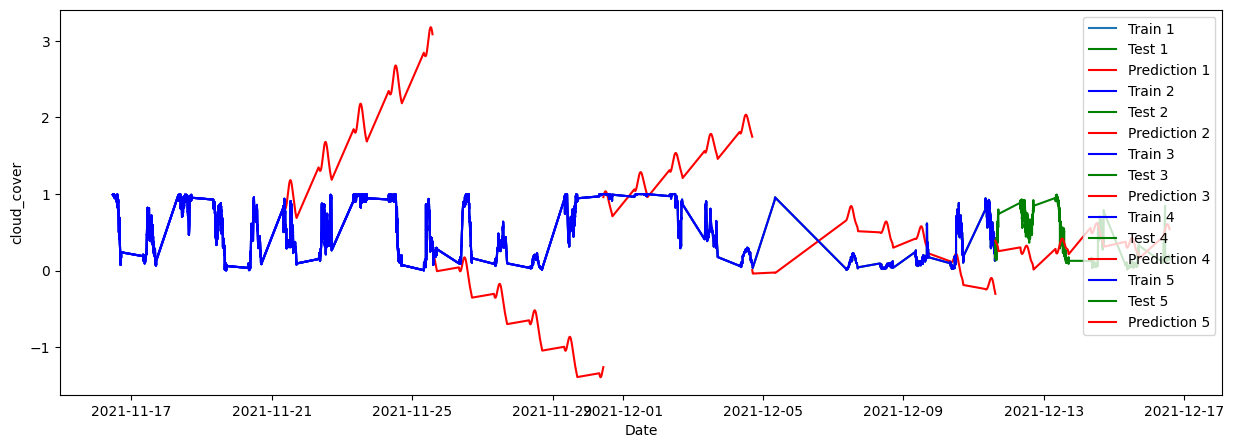

In [15]:
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('cloud_cover')
sns.lineplot(x= train1['ds'], y=train1["y"],label = 'Train 1')
sns.lineplot(x= test1['ds'], y=test1["y"],label = 'Test 1' , color = 'green') 
sns.lineplot(x= pred1['ds'], y=pred1["yhat"],label = 'Prediction 1', color = 'red') 

sns.lineplot(x= train2['ds'], y=train2["y"],label = 'Train 2',color = 'blue')
sns.lineplot(x= test2['ds'], y=test2["y"],label = 'Test 2', color = 'green') 
sns.lineplot(x= pred2['ds'], y=pred2["yhat"],label = 'Prediction 2', color = 'red') 

sns.lineplot(x= train3['ds'], y=train3["y"],label = 'Train 3',color = 'blue')
sns.lineplot(x= test3['ds'], y=test3["y"],label = 'Test 3', color = 'green') 
sns.lineplot(x= pred3['ds'], y=pred3["yhat"],label = 'Prediction 3', color = 'red') 

sns.lineplot(x= train4['ds'], y=train4["y"],label = 'Train 4',color = 'blue')
sns.lineplot(x= test4['ds'], y=test4["y"],label = 'Test 4', color = 'green') 
sns.lineplot(x= pred4['ds'], y=pred4["yhat"],label = 'Prediction 4', color = 'red') 

sns.lineplot(x= train5['ds'], y=train5["y"],label = 'Train 5',color = 'blue')
sns.lineplot(x= test5['ds'], y=test5["y"],label = 'Test 5', color = 'green') 
sns.lineplot(x= pred5['ds'], y=pred5["yhat"],label = 'Prediction 5', color = 'red') 

In [18]:
tscv = TimeSeriesSplit(n_splits=10)
rmse = []
for train,test in tscv.split(df):
    cv_train, cv_test = df.iloc[train], df.iloc[test]
    model = Prophet()
    model.fit(cv_train)
    pred = model.predict(cv_test)
    true_values = cv_test['y']
    rmse.append(mean_squared_error(true_values, pred['yhat'], squared=False))

13:49:19 - cmdstanpy - INFO - Chain [1] start processing
13:49:20 - cmdstanpy - INFO - Chain [1] done processing
13:49:21 - cmdstanpy - INFO - Chain [1] start processing
13:49:21 - cmdstanpy - INFO - Chain [1] done processing
13:49:22 - cmdstanpy - INFO - Chain [1] start processing
13:49:25 - cmdstanpy - INFO - Chain [1] done processing
13:49:25 - cmdstanpy - INFO - Chain [1] start processing
13:49:28 - cmdstanpy - INFO - Chain [1] done processing
13:49:29 - cmdstanpy - INFO - Chain [1] start processing
13:49:33 - cmdstanpy - INFO - Chain [1] done processing
13:49:34 - cmdstanpy - INFO - Chain [1] start processing
13:49:38 - cmdstanpy - INFO - Chain [1] done processing
13:49:39 - cmdstanpy - INFO - Chain [1] start processing
13:49:49 - cmdstanpy - INFO - Chain [1] done processing
13:49:52 - cmdstanpy - INFO - Chain [1] start processing
13:50:07 - cmdstanpy - INFO - Chain [1] done processing
13:50:08 - cmdstanpy - INFO - Chain [1] start processing
13:50:38 - cmdstanpy - INFO - Chain [1]

In [19]:
print(np.mean(rmse))

0.682492235912601
